In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import models
from PIL import Image
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('/kaggle/input/cloud-type-classification2/train.csv')

In [88]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])  
        image = Image.open(img_name).convert("RGB") 
        label = self.annotations.iloc[idx, 1]  

        if self.transform:
            image = self.transform(image)

        return image, label


In [89]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset = CustomDataset(csv_file='/kaggle/input/cloud-type-classification2/train.csv',
                        root_dir='/kaggle/input/cloud-type-classification2/images/train',
                        transform=transform)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


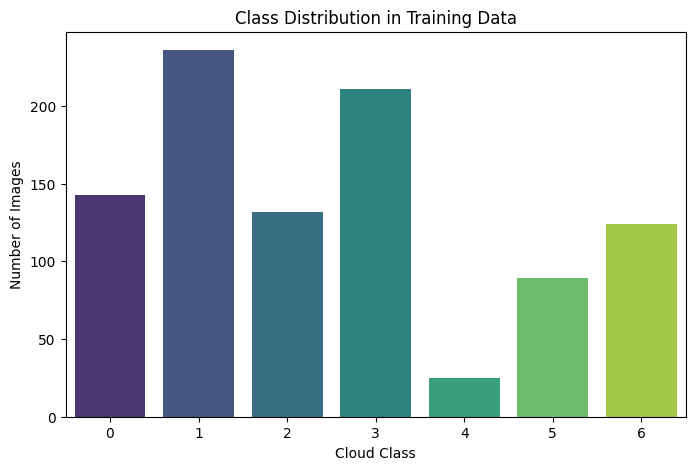

In [90]:
class_counts = df['label'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Cloud Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Data")
plt.show()

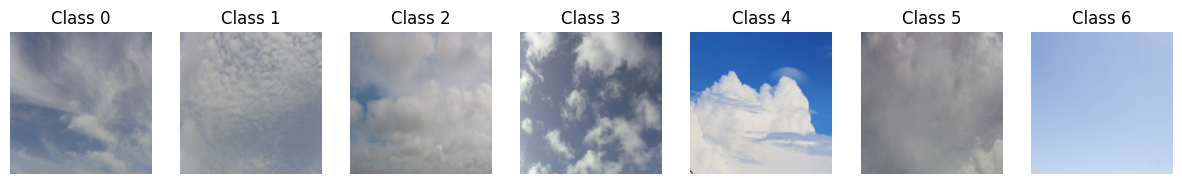

In [91]:
import matplotlib.pyplot as plt
import random

class_images = {i: None for i in range(7)}

for img, label in dataset:
    label = int(label)  
    if class_images[label] is None:
        class_images[label] = img
    if None not in class_images.values():  
        break  

fig, axes = plt.subplots(1, 7, figsize=(15, 5))
for i, ax in enumerate(axes):
    if class_images[i] is not None:
        ax.imshow(class_images[i].permute(1, 2, 0))  
        ax.set_title(f"Class {i}")
        ax.axis("off")
plt.show()


In [92]:
import torchvision.models as models
import torch.nn as nn

model = models.efficientnet_b0(pretrained=True)

num_ftrs = model.classifier[1].in_features  
model.classifier[1] = nn.Linear(num_ftrs, 7)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [93]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [94]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for img, label in train_loader:
            img, label = img.to(device), label.to(device)

            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for img, label in val_loader:
                img, label = img.to(device), label.to(device)
                output = model(img)
                loss = criterion(output, label)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f} | Validation Loss = {val_loss:.4f}")

    return model


In [95]:
trained_model = train_model(model, train_loader, val_loader, epochs=7, lr=0.001)

Epoch 1: Train Loss = 0.7443 | Validation Loss = 5.6700
Epoch 2: Train Loss = 0.1535 | Validation Loss = 3.2801
Epoch 3: Train Loss = 0.1075 | Validation Loss = 1.4194
Epoch 4: Train Loss = 0.0743 | Validation Loss = 0.3967
Epoch 5: Train Loss = 0.1373 | Validation Loss = 0.3504
Epoch 6: Train Loss = 0.0564 | Validation Loss = 0.0978
Epoch 7: Train Loss = 0.0324 | Validation Loss = 0.1539


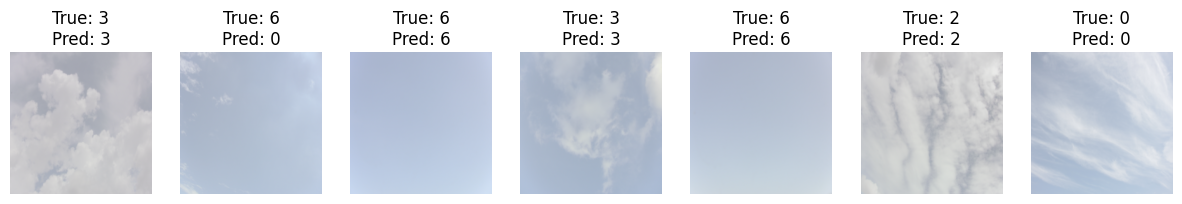

In [96]:
import matplotlib.pyplot as plt
import torch

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)  

plt.figure(figsize=(15, 5))
for i in range(7):  
    img = images[i].cpu().numpy().transpose((1, 2, 0))  
    img = (img * 0.5) + 0.5 
    
    plt.subplot(1, 7, i + 1)
    plt.imshow(img)
    plt.title(f"True: {labels[i].item()}\nPred: {preds[i].item()}")
    plt.axis("off")

plt.show()
